# Bank customers retirement predictions
![image-9.png](https://manelite.jp/wp-content/uploads/2019/12/iStock-1128477281-486x290.jpg)

 * You work as a data scientist at a major bank in NYC and you have been tasked to develop a model that can predict whether a customer is able to retire or not based on  his/her features. Features are his/her age and 401K savings (retirement savings in the U.S.).

## Step #0: Preparation
### Import Libraries

In [1]:
# libraries for analysis dataset
import pandas as pd
import numpy as np
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# libraries for preprocessing
from sklearn.model_selection import train_test_split
from feature_engine.imputation import RandomSampleImputer, MeanMedianImputer, ArbitraryNumberImputer,EndTailImputer
from feature_engine.discretisation import EqualFrequencyDiscretiser,EqualWidthDiscretiser
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from feature_engine import imputation as im
from sklearn.model_selection import GridSearchCV
# libraries for model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlens.ensemble import SuperLearner
# libraries for scoring
from sklearn.metrics import (roc_auc_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score,
                             classification_report)
# alarms
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

[MLENS] backend: threading


### Functions for visualization

In [2]:
# let's see diagnostic plots
def diagnostic_plots(data, variable):
    fig = plt.figure()
    plt.figure(figsize = (16, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(data[variable], bins = 30)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)
    stats.probplot(data[variable], dist = 'norm', plot = plt)
    plt.ylabel(variable)
    plt.subplot(1, 3, 3)
    sns.boxplot(y = data[variable])
    plt.title('Boxplot')
    plt.show()

In [3]:
# show missing data in percentage
def missing_data(X,y,color_list,title):
    missing= X.isnull().sum()[X.isnull().sum() !=0].sort_values(ascending=False)
    missing=pd.DataFrame(missing.reset_index())
    missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
    missing['percentage (%)']=((missing['missing_count'])/len(X))*100
    plt.figure(figsize=(15,4))
    sns.barplot(y=missing['features'],x=missing['percentage (%)'], color=color_list)
    plt.title(title)
    return missing

In [4]:
# visualization of imputation
def make_plot(X_train, variable, variable_1, variable_2,variable_3,variable_4,variable_5):
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(111)
    X_train[variable].plot(kind='kde', ax=ax)
    X_train[variable_1].plot(kind='kde', ax=ax,color='yellow',label='MeanMedianImputer(mean)')
    X_train[variable_2].plot(kind='kde', ax=ax, color='red', label='MeanMedianImputer(median)')
    X_train[variable_3].plot(kind='kde', ax=ax, color='green', label='RandomSampleImputer')
    X_train[variable_4].plot(kind='kde', ax=ax, color='purple', label='ArbitraryNumberImputer')
    X_train[variable_5].plot(kind='kde', ax=ax, color='pink', label='EndTailImputer')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')

# checking for outliers    
    plt.figure(figsize=(10,3))
    sns.boxplot(data=X_train[[variable,variable_1, variable_2, variable_3, variable_4, variable_5]], color='royalblue')
    plt.xticks(rotation = 90)
    plt.title('BoxPlot after Imputation')
    plt.show()

# correlation matrix
    corr = pd.concat([X_train[[variable,variable_1, variable_2, variable_3, variable_4, variable_5]], y_train], axis=1).corr().round(2)
    fig = plt.figure(figsize=(5, 5))
    sns.heatmap(corr, annot = True, cmap='RdBu')
    plt.title('Correlation Matrix after Imputation')
    plt.show()
    
# for variance
    print('Original variable variance:', X_train[variable].var()) 
    print('Variance after median imputation:', X_train[variable_1].var())
    print('Variance after mean imputation:', X_train[variable_2].var())
    print('Variance after random imputer:', X_train[variable_3].var())
    print('Variance after arbitrary imputer:', X_train[variable_4].var())
    print('Variance after endTail imputer:', X_train[variable_5].var())

In [5]:
# visualization of discretiser
def discretisation_plot(X_train_copy1, X_test_copy1, X_train_copy2, X_test_copy2,variable):
    t1 = X_train_copy1.groupby([variable])[variable].count() / len(X_train_copy1)
    t2 = X_test_copy1.groupby([variable])[variable].count() / len(X_test_copy1)
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar()
    plt.title('With EqualFrequencyDiscretiser')
    plt.xticks(rotation=0)
    plt.ylabel('Number of observations per bin');
    plt.show()
    t1 = X_train_copy2.groupby([variable])[variable].count() / len(X_train_copy2)
    t2 = X_test_copy2.groupby([variable])[variable].count() / len(X_test_copy2)
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar()
    plt.title('With EqualWidthDiscretiser')
    plt.xticks(rotation=0)
    plt.ylabel('Number of observations per bin');
    plt.show()
    
# checking for outliers
def box_discretisation_plot(X,X_copy1,X_copy2,variable):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    X[variable].plot.box(title="Before discretization")
    plt.subplot(1,3,2)
    X_copy1[variable].plot.box(title="After EqualFrequencyDiscretiser")
    plt.subplot(1,3,3)
    X_copy2[variable].plot.box(title="After EqualWidthDiscretiser")

In [6]:
results = pd.DataFrame(columns=['modelName', 'accuracy_test', 'rocauc_test','precision_test', 'recall_test', 'f1_test'])
# define function to show the results
def show_results(df):
    r = df.sort_values(by =['accuracy_test', 'rocauc_test', 'precision_test','recall_test','f1_test'], ascending = False)
    return r

In [7]:
# define function to show the results for classifier
def score_show(name,  _gridSearch, X_train, X_test, y_train, y_test):

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3)) 
    
    print('Train: ')
    y_pred_train = _gridSearch.predict(X_train)  
    print('accuracy %s' % accuracy_score(y_train, y_pred_train))
    axes[0].set_title('Train Confusion Matrix')
    cm = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(cm, annot = True, fmt = 'd', ax = axes[0], cmap=plt.cm.RdBu)    
    print(classification_report(y_train, y_pred_train))
    print('------------------------------------------------------')
    print('Test: ')
    y_pred_test =  _gridSearch.predict(X_test)    
    print('accuracy %s' % accuracy_score(y_test, y_pred_test))
    axes[1].set_title('Test Confusion Matrix')
    cm_t = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_t, annot = True, fmt = 'd', ax = axes[1], cmap=plt.cm.RdBu)    
    print(classification_report(y_test, y_pred_test))

    results.loc[len(results.index)] = [name, 
                                       accuracy_score(y_test,y_pred_test), 
                                       #accuracy_score(y_train, y_pred_train), 
                                       roc_auc_score(y_test, y_pred_test), 
                                      # roc_auc_score(y_train, y_pred_train),
                                       precision_score(y_test, y_pred_test),
                                       #precision_score(y_train, y_pred_train),
                                       recall_score(y_test, y_pred_test),
                                       #recall_score(y_train, y_pred_train),
                                       f1_score(y_test, y_pred_test)]
                                       #f1_score(y_train, y_pred_train)]

## Step #1 : Import dataset

In [8]:
# load the dataset
data = pd.read_csv('../Bank_Customer_retirement_TP.csv')
data.shape

(500, 4)

In [9]:
# show the first 5 rows of the dataset
data.head()

,Customer ID,Age,401K Savings,Retire
0,0,39.180417,322349.8740,0
1,1,56.101686,768671.5740,1
2,2,57.023043,821505.4718,1
3,3,NaN,494187.4850,0
4,4,54.728823,691435.7723,1


In [10]:
# show the last 5 rows of the dataset
data.tail()

,Customer ID,Age,401K Savings,Retire
495,495,46.678128,704243.0776,1
496,496,43.545007,483175.9998,0
497,497,46.476724,354919.1987,0
498,498,50.903631,639789.9219,1
499,499,38.590586,491310.0096,0


In [11]:
# delete the variable ID
data = data.drop(['Customer ID'],axis=1)

In [12]:
# information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           478 non-null    float64
 1   401K Savings  484 non-null    float64
 2   Retire        500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [13]:
# description of the dataset
data.describe()

,Age,401K Savings,Retire
count,478.000000,484.000000,500.000000
mean,46.828904,536610.568002,0.500000
std,7.834280,187527.555076,0.500501
min,25.000000,33837.932150,0.000000
25%,41.303515,381909.653150,0.000000
50%,46.711140,535544.341550,0.500000
75%,52.726929,683034.260050,1.000000
max,70.000000,1000000.000000,1.000000


# Step #2 : Analysis 
## Step #2.1: Exploratory data analysis

<AxesSubplot:xlabel='Retire', ylabel='count'>

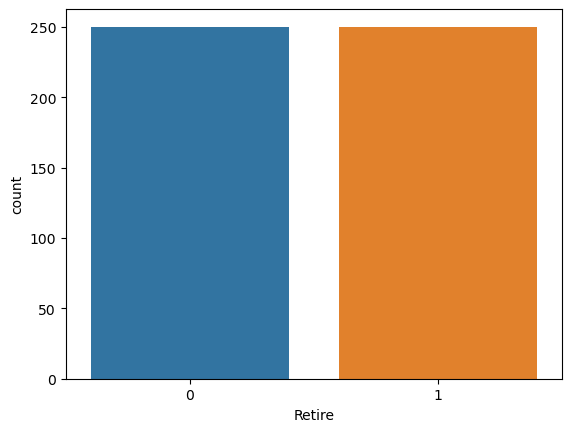

In [14]:
# describes the count of the class labels
sns.countplot(data['Retire'])

Dependent variable ‘Retire’ is balanced.

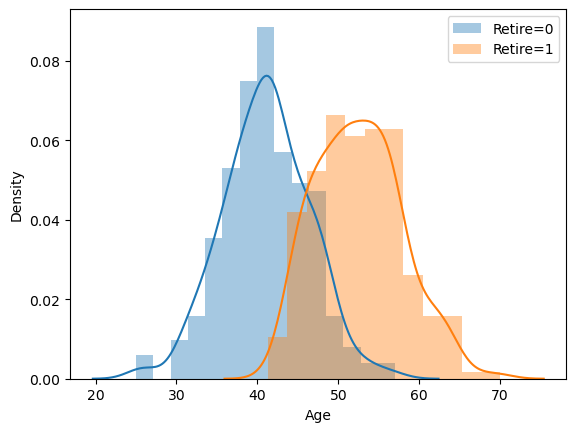

In [15]:
# let's see age distribution
sns.distplot(data[data['Retire']==0]['Age'], label='Retire=0' )
sns.distplot(data[data['Retire']==1]['Age'], label='Retire=1' )
plt.legend()
plt.show()

 People who retire between the ages of 48 and 58

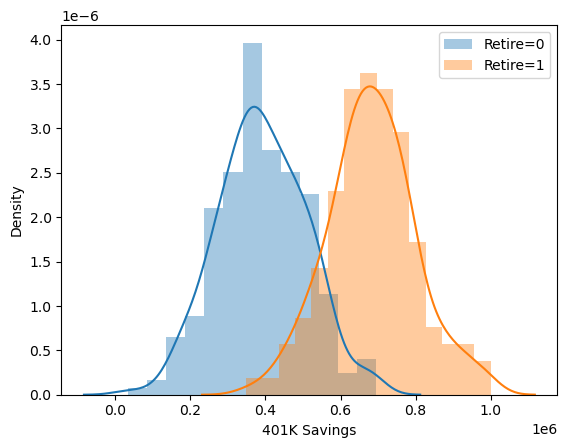

In [16]:
# let's see distribution "401K Savings"
sns.distplot(data[data['Retire']==0]['401K Savings'], label='Retire=0' )
sns.distplot(data[data['Retire']==1]['401K Savings'], label='Retire=1' )
plt.legend()
plt.show()

People who retire made deposits from 620.000$ to $780.000

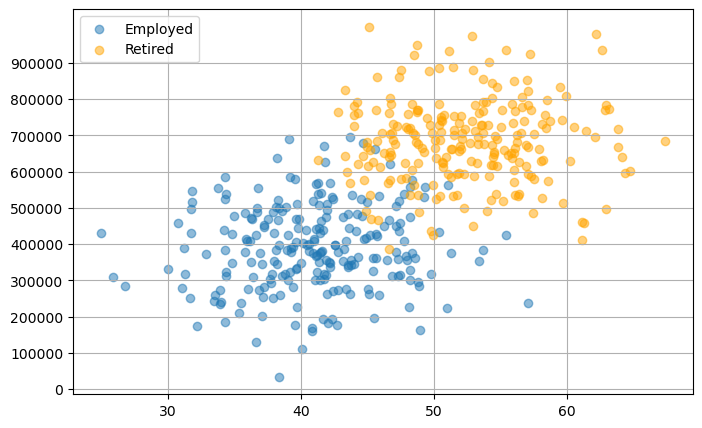

In [17]:
# let's see distribution 
plt.figure(figsize=(8,5))
plt.subplot()
plt.scatter(x = data[data.Retire == 0]['Age'],
            y = data[data.Retire == 0]['401K Savings'],
            alpha = 0.5)  
plt.scatter(x = data[data.Retire == 1]['Age'],
            y = data[data.Retire == 1]['401K Savings'],
            color = 'orange',
            alpha = 0.5)
plt.yticks(ticks=np.arange(0,1000000,100000))
plt.legend(['Employed','Retired'])
plt.grid()
plt.show()

* People who retire between the ages of 48 and 58 made deposits from 620.000$ to $780.000
* People who do not retire from 38 to 42 years old make deposits from 380.000$ to $450.000

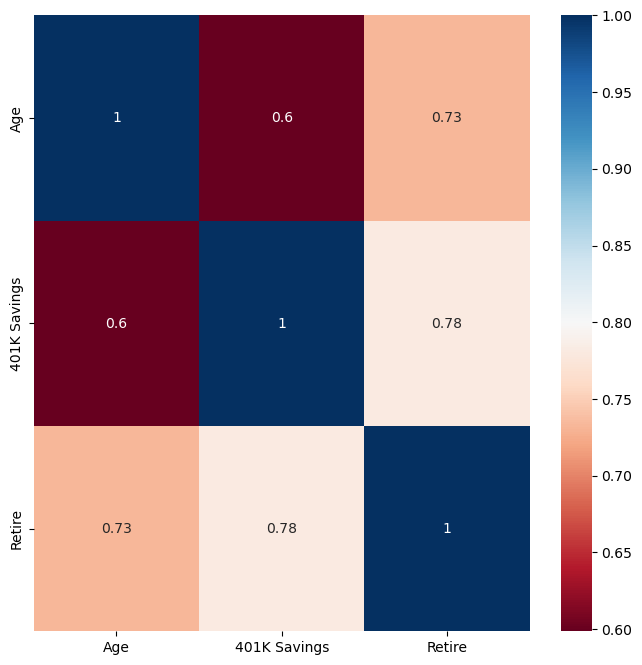

In [18]:
# correlation matrix
plt.figure(figsize=(8,8))
sns.heatmap(
    data.corr(),
    annot=True,
    cmap="RdBu"
)
plt.show()

From the correlation matrix, we can see that the independent variables correlate well with the target value and visualize the relationship between the independent variables.

In [19]:
# let's check if there are missing values
data.isnull().mean()

Age             0.044
401K Savings    0.032
Retire          0.000
dtype: float64

<Figure size 640x480 with 0 Axes>

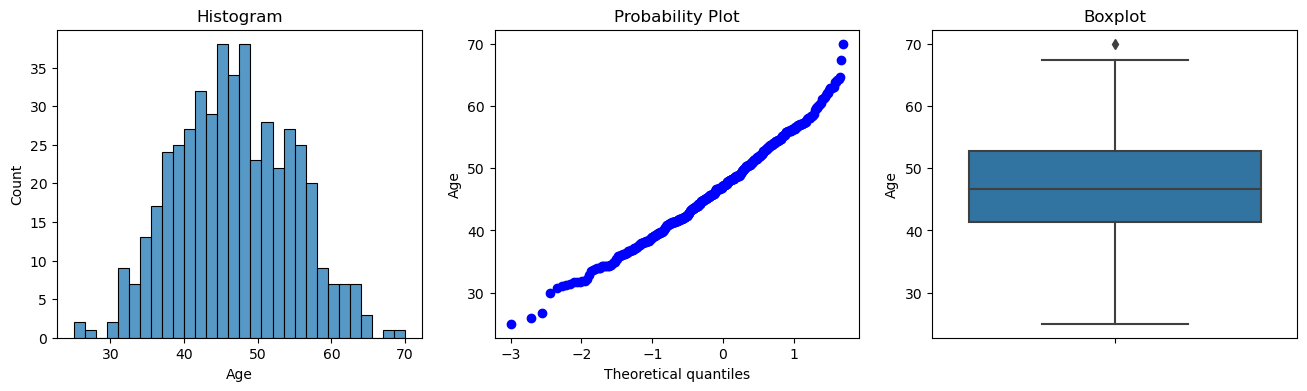

In [20]:
# let's see diagnostic plots "Age" variable
diagnostic_plots(data, 'Age')

* Histogram - the normal distribution
* Probability Plot - a linear model
* Boxplot - has an outlier

<Figure size 640x480 with 0 Axes>

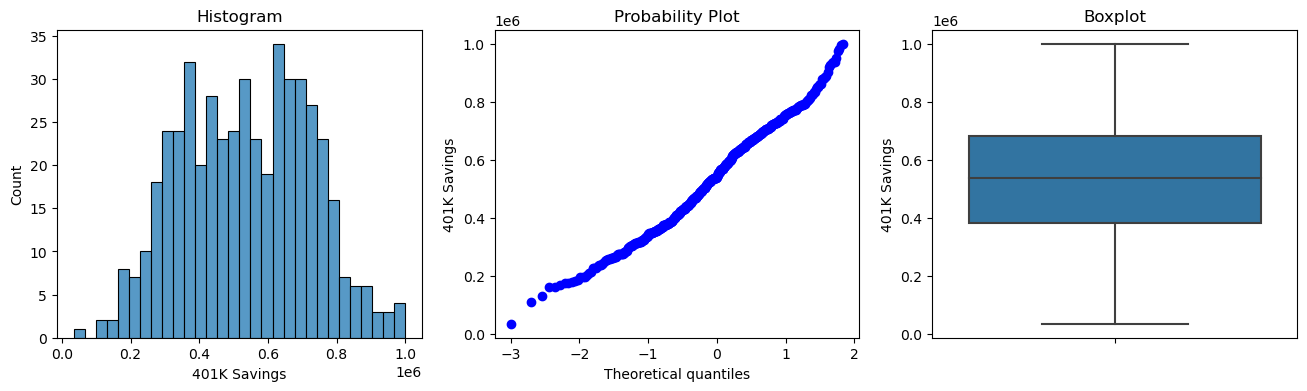

In [21]:
# let's see diagnostic plots "401K Savings" variable
diagnostic_plots(data, '401K Savings')

* Histogram - the skewed distribution
* Probability Plot -a linear model
* Boxplot - hasn't any outliers

## Splitting dataset 

In [22]:
# create independent variable X
X = data.drop(['Retire'],axis=1)
X

,Age,401K Savings
0,39.180417,322349.8740
1,56.101686,768671.5740
2,57.023043,821505.4718
3,NaN,494187.4850
4,54.728823,691435.7723
...,...,...
495,46.678128,704243.0776
496,43.545007,483175.9998
497,46.476724,354919.1987
498,50.903631,639789.9219


In [23]:
# create dependent variable y
y = data['Retire']
y

0      0
1      1
2      1
3      0
4      1
      ..
495    1
496    0
497    0
498    1
499    0
Name: Retire, Length: 500, dtype: int64

In [24]:
# splitting dataset on train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_test.shape

((400, 2), (100, 2))

## Step #2.2: Imputation  Analysis

### Missing Data Imputation '401K Savings', 'Age'

,features,missing_count,percentage (%)
0,Age,17,4.25
1,401K Savings,15,3.75


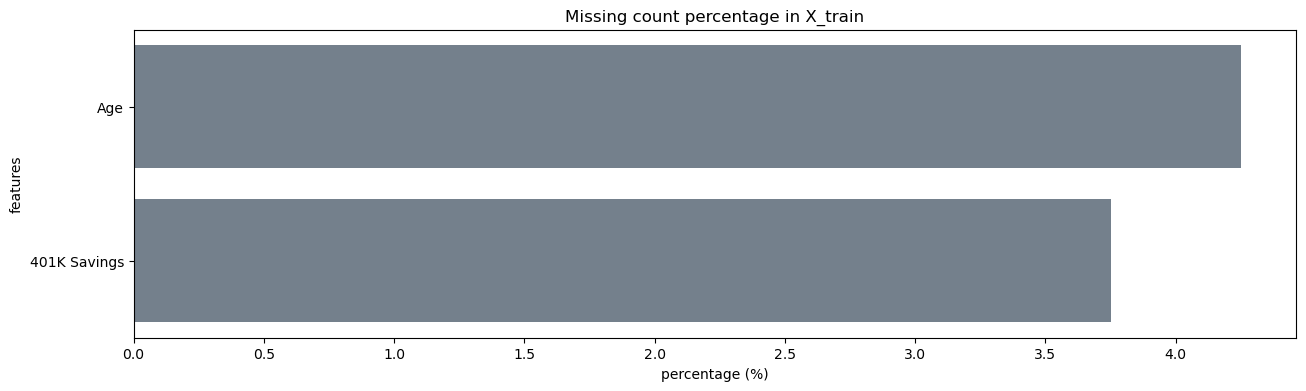

In [25]:
# show missing data in percentage in X_train
missing_data(X_train,y_train,'slategrey', 'Missing count percentage in X_train')

The "Age" variable is missing 0.4% of the data and the "401K Savings" variable is missing 0.3% of the data in train data.

,features,missing_count,percentage (%)
0,Age,5,5.0
1,401K Savings,1,1.0


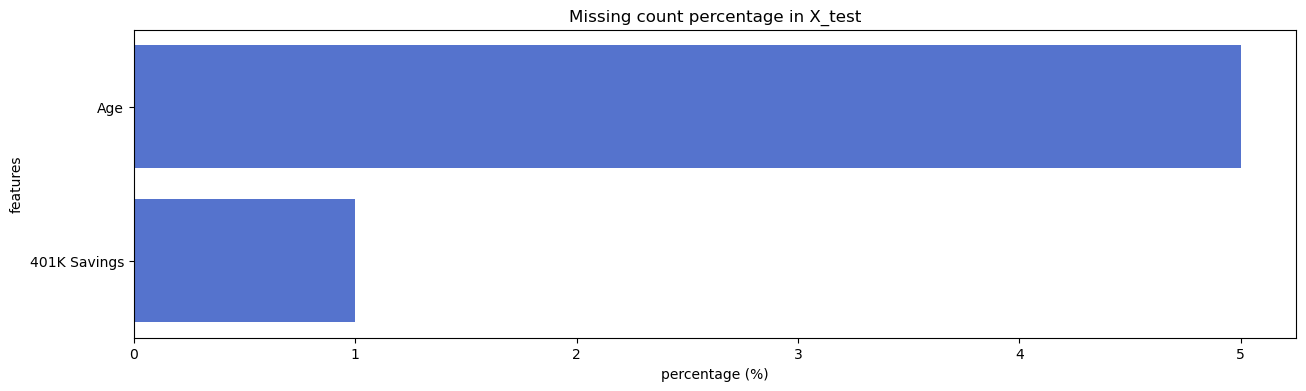

In [26]:
# show missing data in percentage in X_test
missing_data(X_test,y_test,'royalblue', 'Missing count percentage in X_test')

The "Age" variable is missing 0.5% of the data and the "401K Savings" variable is missing 0.1% of the data in test data.

#### Mean Median Imputer

In [27]:
X_train['401K Savings_mean'] = X_train['401K Savings'].copy()
X_test['401K Savings_mean'] = X_test['401K Savings'].copy()
X_train['Age_mean'] = X_train['Age'].copy()
X_test['Age_mean'] = X_test['Age'].copy()

X_train['401K Savings_median'] = X_train['401K Savings'].copy()
X_test['401K Savings_median'] = X_test['401K Savings'].copy()
X_train['Age_median'] = X_train['Age'].copy()
X_test['Age_median'] = X_test['Age'].copy()

In [28]:
mean_im= MeanMedianImputer(imputation_method='mean', variables=['401K Savings_mean','Age_mean'])
mean_im.fit(X_train)
X_train = mean_im.transform(X_train)
X_test = mean_im.transform(X_test)

In [29]:
median_im=MeanMedianImputer(imputation_method='median', variables=['401K Savings_median','Age_median'])
median_im.fit(X_train)
X_train = median_im.transform(X_train)
X_test = median_im.transform(X_test)

#### Random Sample Imputer

In [30]:
X_train['401K Savings_random'] = X_train['401K Savings'].copy()
X_test['401K Savings_random'] = X_test['401K Savings'].copy()
X_train['Age_random'] = X_train['Age'].copy()
X_test['Age_random'] = X_test['Age'].copy()

In [31]:
random_im=RandomSampleImputer(variables=['401K Savings_random','Age_random'])
random_im.fit(X_train)
X_train= random_im.transform(X_train)
X_test= random_im.transform(X_test)

#### Arbitrary Number Imputer

In [32]:
X_train['401K Savings_arb'] = X_train['401K Savings'].copy()
X_test['401K Savings_arb'] = X_test['401K Savings'].copy()
X_train['Age_arb'] = X_train['Age'].copy()
X_test['Age_arb'] = X_test['Age'].copy()

In [33]:
arb_im= ArbitraryNumberImputer(arbitrary_number=-1, variables=['401K Savings_arb','Age_arb'])
arb_im.fit(X_train)
X_train= arb_im.transform(X_train)
X_test= arb_im.transform(X_test)

#### End Tail Imputer

In [34]:
X_train['401K Savings_endTail'] = X_train['401K Savings'].copy()
X_test['401K Savings_endTail'] = X_test['401K Savings'].copy()
X_train['Age_endTail'] = X_train['Age'].copy()
X_test['Age_endTail'] = X_test['Age'].copy()

In [35]:
endTail_im = EndTailImputer(imputation_method = 'gaussian', tail = 'right', 
                                variables = ['401K Savings_endTail', 'Age_endTail'])
endTail_im.fit(X_train)
X_train= endTail_im.transform(X_train)
X_test= endTail_im.transform(X_test)

### '401K Savings' variable imputation analysis

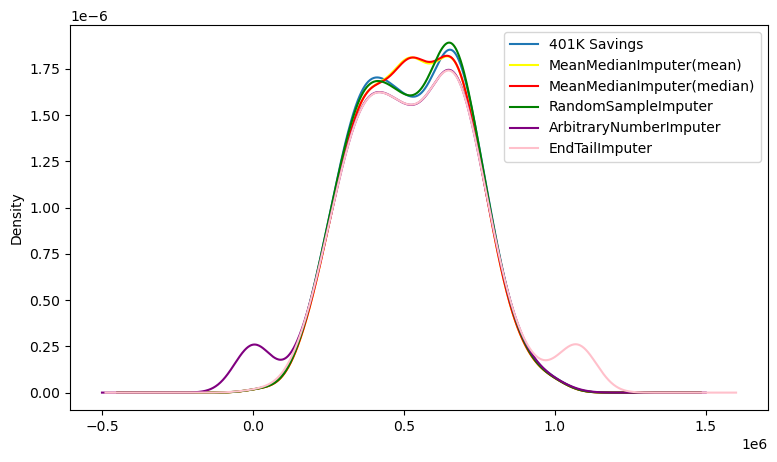

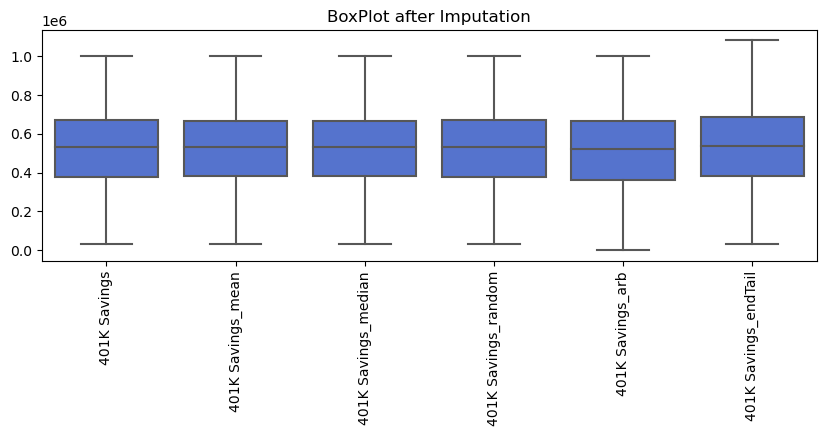

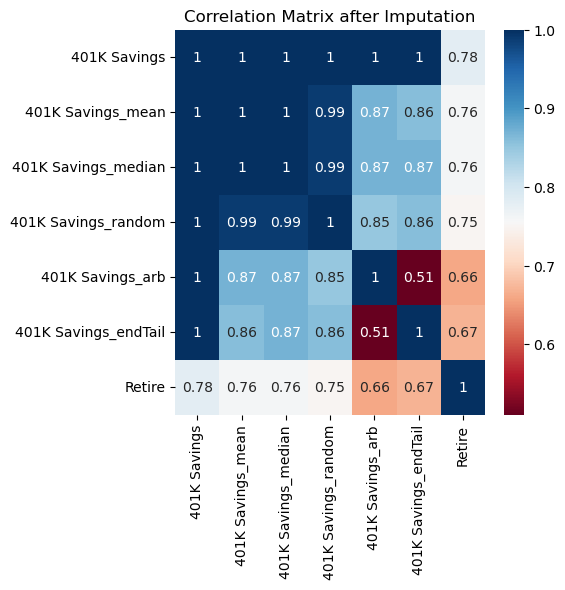

Original variable variance: 33571847323.081745
Variance after median imputation: 32309747799.65762
Variance after mean imputation: 32310028755.621635
Variance after random imputer: 33260600996.348064
Variance after arbitrary imputer: 42420876057.5962
Variance after endTail imputer: 43242684921.319115


In [36]:
make_plot(X_train,'401K Savings','401K Savings_mean','401K Savings_median','401K Savings_random','401K Savings_arb','401K Savings_endTail')

Based on the analysis, the best imputation for "401K Savings" variable would be the mean or median values.

### 'Age' variable imputation analysis

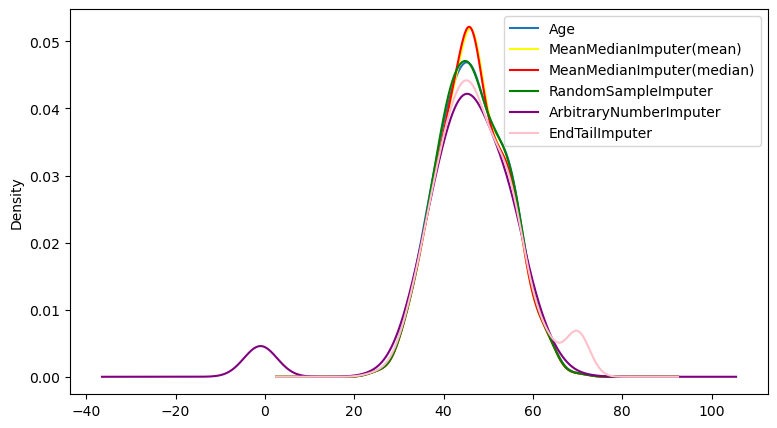

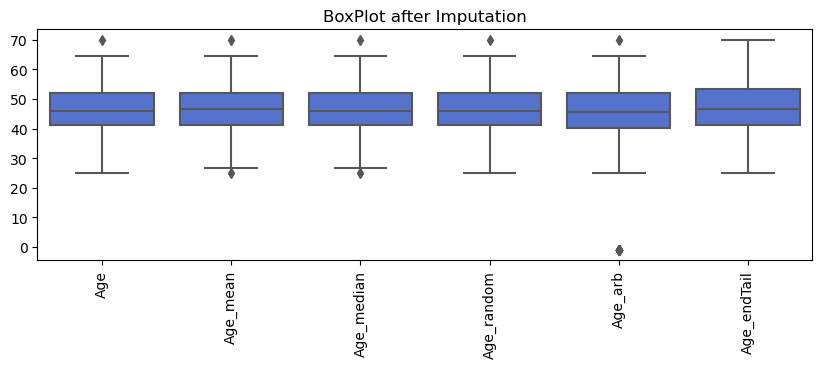

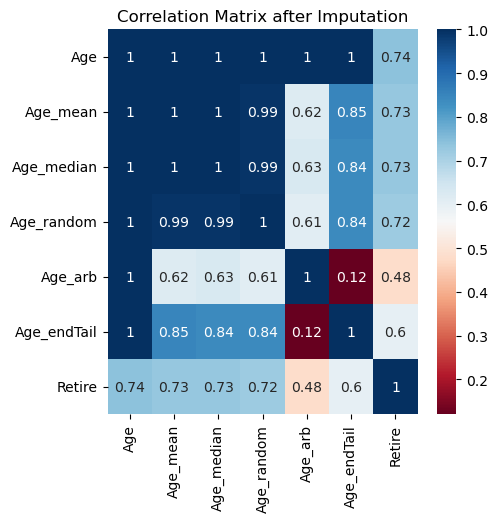

Original variable variance: 61.247678205797165
Variance after median imputation: 58.63812800655268
Variance after mean imputation: 58.64621709411868
Variance after random imputer: 60.31503050086233
Variance after arbitrary imputer: 150.7173858745791
Variance after endTail imputer: 81.12592684854204


In [37]:
make_plot(X_train,'Age','Age_mean','Age_median','Age_random','Age_arb','Age_endTail')

Based on the analysis, the best imputation for "Age" variable would be the mean or median values.

#### Finding the best Imputation technique using GridSearchCV

In [38]:
# training using Pipeline with Grid Search
im_pipe = Pipeline([
        ('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
        ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
        ('RandomForestClassifier', RandomForestClassifier())
 ])
     
im_param= [{
        'Imputation_Age' : [
            im.ArbitraryNumberImputer(variables=['Age']),
            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
            im.MeanMedianImputer(imputation_method='median',variables=['Age']),
            im.RandomSampleImputer(variables=['Age']),
            im.EndTailImputer(imputation_method = 'gaussian', tail = 'right', variables =['Age'])
        ],
        'Imputation_401K' : [
            im.ArbitraryNumberImputer(variables=['401K Savings']),
            im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
            im.MeanMedianImputer(imputation_method='median',variables=['401K Savings']),
            im.RandomSampleImputer(variables=['401K Savings']),
            im.EndTailImputer(imputation_method = 'gaussian', tail = 'right', variables =['401K Savings'])
        ]
            }]
im_gridSearch = GridSearchCV(im_pipe, im_param, cv = 5, n_jobs = -1, scoring = 'accuracy')
im_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'Imputation_401K': [ArbitraryNumberImputer(variables=['401K '
                                                                                'Savings']),
                                              MeanMedianImputer(imputation_method...
                                                                           'Savings']),
                                              RandomSampleImputer(variables=['401K '
                                                                             'Savings']),
                                              EndTailImputer(variables=['401K '
                                                                        'Savings'])],
                          'Imputation_Age': [ArbitraryNumberImputer(variables=['Age']),
                                             MeanMedianImputer(imputation_method='mean',
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age']),
                                             RandomSampleImputer(variables=['Age']),
                                             EndTailImputer(variables=['Age'])]}],
             scoring='accuracy')

In [39]:
# selection of the best parameters
im_gridSearch.best_params_

{'Imputation_401K': MeanMedianImputer(variables=['401K Savings']),
 'Imputation_Age': MeanMedianImputer(variables=['Age'])}

In [40]:
# score
im_gridSearch.best_score_

0.9424999999999999

GridSearch found the best imputation of the variables is mean or median values.

## Step #2.3: Discretisation Analysis
 Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretisation is also called binning, where bin is an alternative name for interval. Discretization helps handle outliers and may improve value spread in skewed variables

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_test.shape

((400, 2), (100, 2))

In [42]:
# imputation missing data
mean_im= MeanMedianImputer(imputation_method='mean', variables=['401K Savings','Age'])
mean_im.fit(X_train)
X_train = mean_im.transform(X_train)
X_test = mean_im.transform(X_test)

#### EqualFrequencyDiscretiser

In [43]:
# divides the scope of possible values into N bins, where each bin carries the same amount of observation
# 1)handles outliers 2)creates discrete variable 3)improve spread
disc = EqualFrequencyDiscretiser(q = 10, variables =['Age'])
disc.fit(X_train)
X_train_eFdisc= disc.transform(X_train)
X_test_eFdisc= disc.transform(X_test)

#### EqualWidthDiscretiser

In [44]:
# divides the scope of possible values into N bins of the same width:
# 1)handles outliers 2)creates discrete variable 3)doesn't improve spread
disc = EqualWidthDiscretiser(bins= 10, variables =['Age'])
disc.fit(X_train)
X_train_eWdisc= disc.transform(X_train)
X_test_eWdisc= disc.transform(X_test)

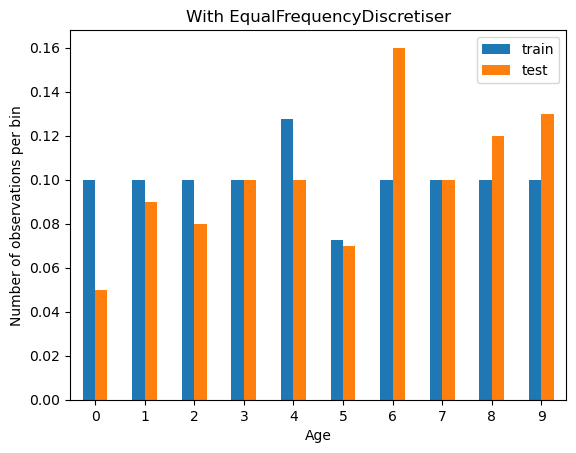

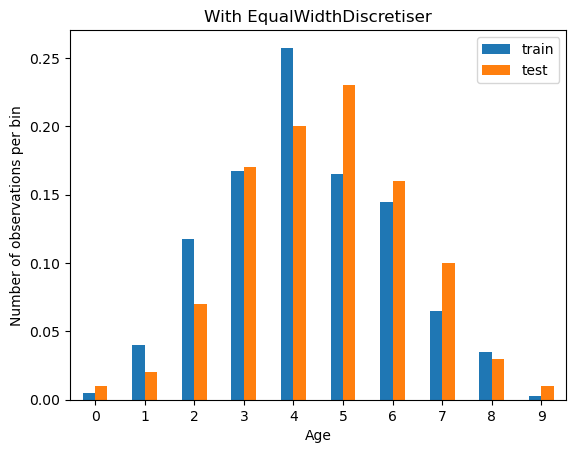

In [45]:
# visualization
discretisation_plot( X_train_eFdisc,X_test_eFdisc,X_train_eWdisc,X_test_eWdisc,"Age")

Creates discrete variable and improve spread

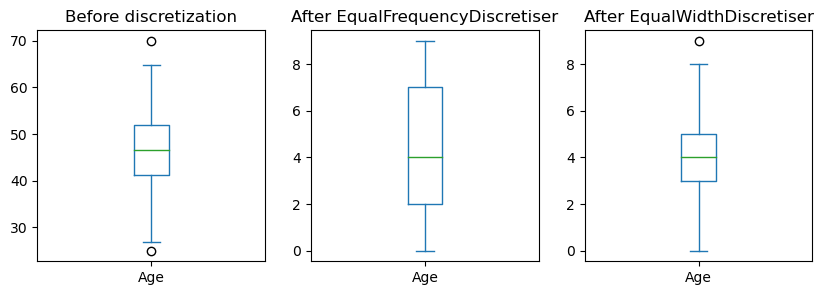

In [46]:
# checking for outliers
box_discretisation_plot(X_train, X_train_eFdisc,X_train_eWdisc,'Age')

After Descretization the outliers were smaller.

## Step #2.4: Standard Scaler Analysis

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_test.shape

((400, 2), (100, 2))

In [48]:
# imputation missing data
mean_im= MeanMedianImputer(imputation_method='mean', variables=['401K Savings','Age'])
mean_im.fit(X_train)
X_train = mean_im.transform(X_train)
X_test = mean_im.transform(X_test)

In [49]:
# discretisation "Age" variable
disc = EqualFrequencyDiscretiser(q = 10, variables =['Age'])
disc.fit(X_train)
X_train_eFdisc= disc.transform(X_train)
X_test_eFdisc= disc.transform(X_test)

#### StandardScaler

In [50]:
# centers at zero and sets the variance to 1: 1)preserves the shape of the original distribution 2)preserves outliers
stand_scaler = StandardScaler()
stand_scaler.fit(X_train)
X_train_standScaled= stand_scaler.transform(X_train)
X_test_standScaled= stand_scaler.transform(X_test)
X_train_standScaled = pd.DataFrame(X_train_standScaled, columns=X_train.columns)
X_test_standScaled= pd.DataFrame(X_test_standScaled, columns=X_test.columns)

#### MinMaxScaler

In [51]:
# scaling the variable between 0 and 1: 1)mean,variance varies 2)preserves outliers
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_mmScaled = mm_scaler.transform(X_train)
X_test_mmScaled = mm_scaler.transform(X_test)
X_train_mmScaled = pd.DataFrame(X_train_mmScaled, columns=X_train.columns)
X_test_mmScaled = pd.DataFrame(X_test_mmScaled, columns=X_test.columns)

#### RobustScaler

In [52]:
# scaling to median and IQR: 1)median centered at zero 2)handles outliers
rob_scaler = RobustScaler()
rob_scaler.fit(X_train)
X_train_robScaled= rob_scaler.transform(X_train)
X_test_robScaled= rob_scaler.transform(X_test)
X_train_robScaled= pd.DataFrame(X_train_robScaled, columns=X_train.columns)
X_test_robScaled= pd.DataFrame(X_test_robScaled, columns=X_test.columns)

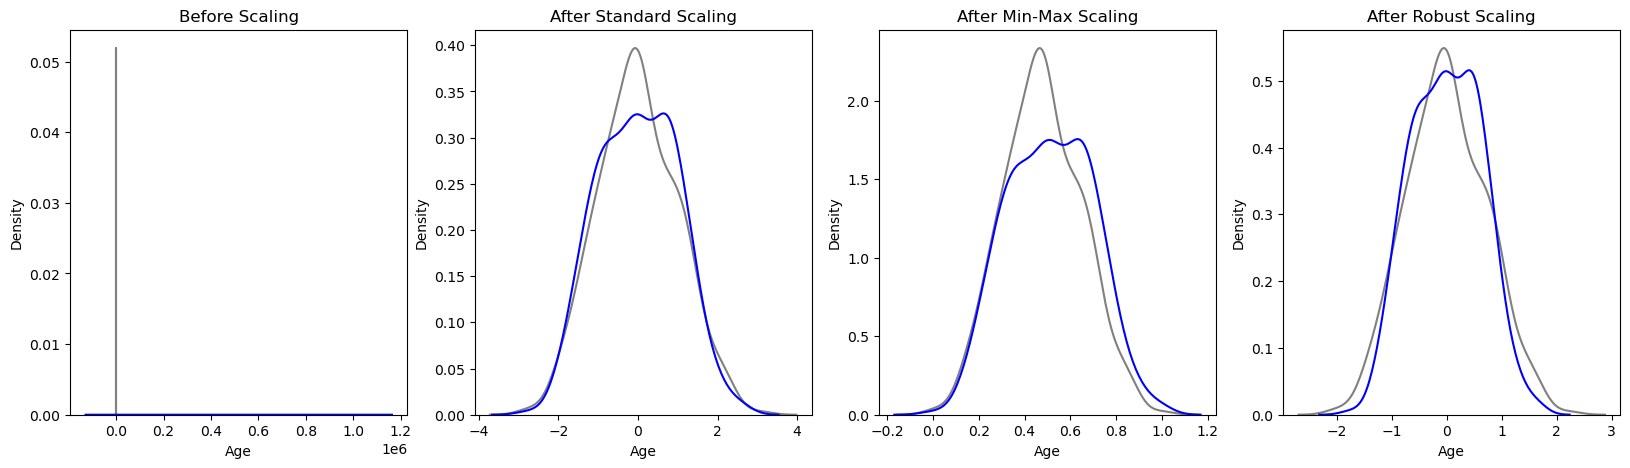

In [53]:
# visualization after standartization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')  
sns.kdeplot(X_train['Age'], ax = ax1, color ='grey')
sns.kdeplot(X_train['401K Savings'], ax = ax1, color ='blue')

ax2.set_title('After Standard Scaling')  
sns.kdeplot(X_train_standScaled['Age'], ax = ax2, color ='grey')
sns.kdeplot(X_train_standScaled['401K Savings'], ax = ax2, color ='blue')

ax3.set_title('After Min-Max Scaling')  
sns.kdeplot(X_train_mmScaled['Age'], ax = ax3, color ='grey')
sns.kdeplot(X_train_mmScaled['401K Savings'], ax = ax3, color ='blue')

ax4.set_title('After Robust Scaling')  
sns.kdeplot(X_train_robScaled['Age'], ax = ax4, color ='grey')
sns.kdeplot(X_train_robScaled['401K Savings'], ax = ax4, color ='blue')

plt.show()

We can see that the scaling normalized the range of independent variables.

# Step #3: Models with Pipeline & GridSearch

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_test.shape

((400, 2), (100, 2))

## Step #3.1: Decision Tree Classifier

In [55]:
# training the model using Pipeline with Grid Search
DT_pipe=Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                  ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                  ('Discretization',EqualFrequencyDiscretiser(q = 10,variables = 'Age')),
                  ('Scaler',StandardScaler()),
                  ('DecisionTreeClassifier', DecisionTreeClassifier())])

params_DT = [{
        'Imputation_Age' : [im.ArbitraryNumberImputer(variables=['Age']),
                            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
                            im.MeanMedianImputer(imputation_method='median', variables=['Age'])],
        'Imputation_401K' : [im.ArbitraryNumberImputer(variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='median',variables=['401K Savings'])],
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables='Age'),
                            EqualFrequencyDiscretiser(q=10,variables='Age'),
                            EqualWidthDiscretiser(bins=5,variables='Age'),
                            EqualWidthDiscretiser(bins=10,variables='Age')],
#         'Scaler' : [StandardScaler(),
#                     RobustScaler(),
#                     MinMaxScaler()],
        'DecisionTreeClassifier__max_depth' : [3,4,5],
        'DecisionTreeClassifier__min_samples_leaf' : [0,1,2],
        'DecisionTreeClassifier__criterion' : ['gini', 'entropy']
    }]

DT_gridSearch = GridSearchCV(estimator = DT_pipe, param_grid = params_DT, cv = 5, n_jobs = -1, scoring = 'accuracy')
DT_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('Discretization',
                                        EqualFrequencyDiscretiser(variables='Age')),
                                       ('Scaler', StandardScaler()),
                                       ('DecisionTreeClassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid=[{'DecisionTreeCla...
                          'Imputation_401K': [ArbitraryNumberImputer(variables=['401K '
                                                                                'Savings']),
                                              MeanMedianImputer(imputation_method='mean',
                                                                variables=['401K '
                                                                           'Savings']),
                                              MeanMedianImputer(variables=['401K '
                                                                           'Savings'])],
                          'Imputation_Age': [ArbitraryNumberImputer(variables=['Age']),
                                             MeanMedianImputer(imputation_method='mean',
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age'])]}],
             scoring='accuracy')

In [56]:
# selection of the best parameters
DT_gridSearch.best_params_

{'DecisionTreeClassifier__criterion': 'gini',
 'DecisionTreeClassifier__max_depth': 4,
 'DecisionTreeClassifier__min_samples_leaf': 1,
 'Discretization': EqualFrequencyDiscretiser(variables='Age'),
 'Imputation_401K': MeanMedianImputer(imputation_method='mean', variables=['401K Savings']),
 'Imputation_Age': ArbitraryNumberImputer(variables=['Age'])}

Train: 
accuracy 0.9575
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       207
           1       0.94      0.97      0.96       193

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400

------------------------------------------------------
Test: 
accuracy 0.93
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        43
           1       0.93      0.95      0.94        57

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



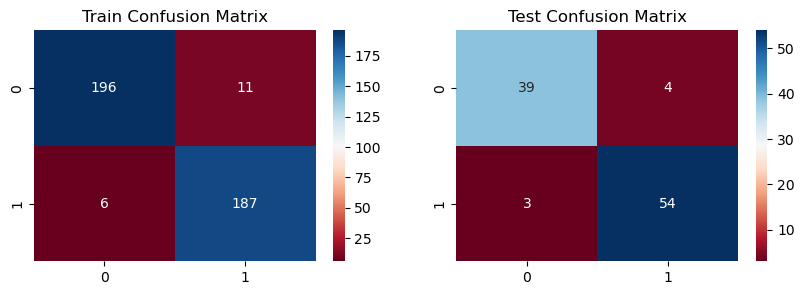

In [57]:
# let's have a look at the classification report and confution matrix
score_show('DecisionTreeClassifier',DT_gridSearch, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 39 times and not retire 54 times. However, the model made a false positive error 4 times and a false negative error 3 times.

## Step #3.2: Random Forest Classifier

In [58]:
# training the model using Pipeline with Grid Search
RF_pipe=Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                  ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                  ('Discretization',EqualFrequencyDiscretiser(q = 10,variables = 'Age')),
#                  ('Scaler',StandardScaler()),
                  ('RandomForestClassifier', RandomForestClassifier())])

params_RF = [{
        'Imputation_Age' : [im.ArbitraryNumberImputer(variables=['Age']),
                            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
                            im.MeanMedianImputer(imputation_method='median',variables=['Age'])],
        'Imputation_401K' : [im.ArbitraryNumberImputer(variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='median',variables=['401K Savings'])],
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables='Age'),
                            EqualFrequencyDiscretiser(q=10,variables='Age'),
                            EqualWidthDiscretiser(bins=5,variables='Age'),
                            EqualWidthDiscretiser(bins=10,variables='Age')],
#        'Scaler' : [StandardScaler(),
#                    RobustScaler(),
#                    MinMaxScaler()],
        'RandomForestClassifier__n_estimators' : [300,400,500],
        'RandomForestClassifier__max_depth' : [1,2,3],
        'RandomForestClassifier__min_samples_leaf' : [0,1],
        'RandomForestClassifier__criterion': ['gini','entropy','log_loss']
    }]

RF_gridSearch = GridSearchCV(estimator = RF_pipe, param_grid = params_RF, cv = 5, n_jobs = -1, scoring = 'accuracy')
RF_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('Discretization',
                                        EqualFrequencyDiscretiser(variables='Age')),
                                       ('RandomForestClassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'Discretization': [EqualFrequencyDiscretiser(...
                          'Imputation_Age': [ArbitraryNumberImputer(variables=['Age']),
                                             MeanMedianImputer(imputation_method='mean',
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age'])],
                          'RandomForestClassifier__criterion': ['gini',
                                                                'entropy',
                                                                'log_loss'],
                          'RandomForestClassifier__max_depth': [1, 2, 3],
                          'RandomForestClassifier__min_samples_leaf': [0, 1],
                          'RandomForestClassifier__n_estimators': [300, 400,
                                                                   500]}],
             scoring='accuracy')

In [59]:
# selection of the best parameters
RF_gridSearch.best_params_

{'Discretization': EqualWidthDiscretiser(variables='Age'),
 'Imputation_401K': MeanMedianImputer(variables=['401K Savings']),
 'Imputation_Age': MeanMedianImputer(variables=['Age']),
 'RandomForestClassifier__criterion': 'entropy',
 'RandomForestClassifier__max_depth': 2,
 'RandomForestClassifier__min_samples_leaf': 1,
 'RandomForestClassifier__n_estimators': 500}

Train: 
accuracy 0.95
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       207
           1       0.95      0.94      0.95       193

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

------------------------------------------------------
Test: 
accuracy 0.94
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.95      0.95      0.95        57

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



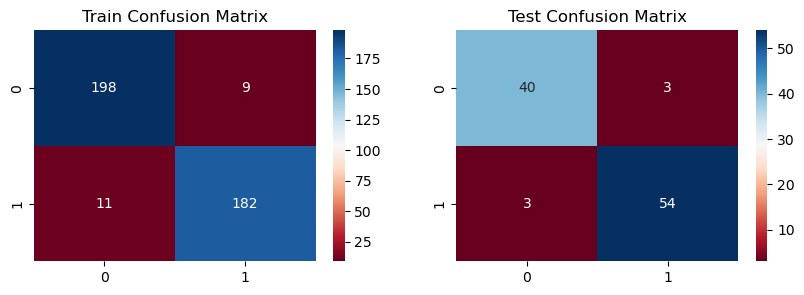

In [60]:
# let's have a look at the classification report and confution matrix
score_show('RandomForestClassifier',RF_gridSearch, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 40 times and not retire 54 times. However, the model made a false positive error 3 times and a false negative error 3 times.

## Step #3.3 K-Nearest Neighbor Classifier

In [61]:
# training the model using Pipeline with Grid Search
KN_pipe=Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                  ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                  ('Discretization',EqualFrequencyDiscretiser(q = 10,variables = 'Age')),
                  ('Scaler',StandardScaler()),
                  ('KNeighborsClassifier', KNeighborsClassifier())])

params_KN = [{
        'Imputation_Age' : [im.ArbitraryNumberImputer(variables=['Age']),
                            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
                            im.MeanMedianImputer(imputation_method='median',variables=['Age'])],
        'Imputation_401K' : [im.ArbitraryNumberImputer(variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='median',variables=['401K Savings'])],
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables='Age'),
                            EqualFrequencyDiscretiser(q=10,variables='Age'),
                            EqualWidthDiscretiser(bins=5,variables='Age'),
                            EqualWidthDiscretiser(bins=10,variables='Age')],
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()],
        'KNeighborsClassifier__n_neighbors': [10,20,30],
        'KNeighborsClassifier__weights': ['uniform', 'distance'],
        'KNeighborsClassifier__metric': ['minkowski', 'euclidean', 'manhattan'],
        'KNeighborsClassifier__p':[1,2,3]
    }]

KN_gridSearch = GridSearchCV(estimator = KN_pipe, param_grid = params_KN, cv = 5, n_jobs = -1, scoring = 'accuracy')
KN_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('Discretization',
                                        EqualFrequencyDiscretiser(variables='Age')),
                                       ('Scaler', StandardScaler()),
                                       ('KNeighborsClassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'Discretization': [Eq...
                                             MeanMedianImputer(imputation_method='mean',
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age'])],
                          'KNeighborsClassifier__metric': ['minkowski',
                                                           'euclidean',
                                                           'manhattan'],
                          'KNeighborsClassifier__n_neighbors': [10, 20, 30],
                          'KNeighborsClassifier__p': [1, 2, 3],
                          'KNeighborsClassifier__weights': ['uniform',
                                                            'distance'],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [62]:
# selection of the best parameters
KN_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables='Age'),
 'Imputation_401K': MeanMedianImputer(imputation_method='mean', variables=['401K Savings']),
 'Imputation_Age': MeanMedianImputer(imputation_method='mean', variables=['Age']),
 'KNeighborsClassifier__metric': 'minkowski',
 'KNeighborsClassifier__n_neighbors': 20,
 'KNeighborsClassifier__p': 1,
 'KNeighborsClassifier__weights': 'uniform',
 'Scaler': StandardScaler()}

Train: 
accuracy 0.9475
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       207
           1       0.95      0.94      0.95       193

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

------------------------------------------------------
Test: 
accuracy 0.92
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        43
           1       0.95      0.91      0.93        57

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



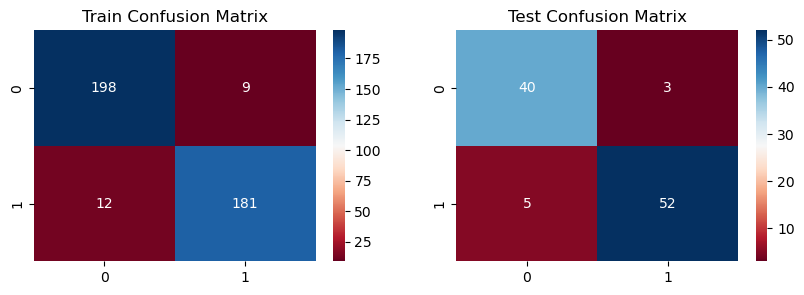

In [63]:
# let's have a look at the classification report and confution matrix
score_show('KNeighborsClassifier',KN_gridSearch, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 40 times and not retire 52 times. However, the model made a false positive error 3 times and a false negative error 5 times.

## Step #3.4: Logistic Regression

In [64]:
# training the model using Pipeline with Grid Search
LR_pipe=Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                  ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                  ('Discretization',EqualFrequencyDiscretiser(q = 10,variables = 'Age')),
                  ('Scaler',StandardScaler()),
                  ('LogisticRegression', LogisticRegression())])

params_LR = [{
        'Imputation_Age' : [im.ArbitraryNumberImputer(variables=['Age']),
                            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
                            im.MeanMedianImputer(imputation_method='median',variables=['Age'])],
        'Imputation_401K' : [im.ArbitraryNumberImputer(variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='median',variables=['401K Savings'])],
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables='Age'),
                            EqualFrequencyDiscretiser(q=10,variables='Age'),
                            EqualWidthDiscretiser(bins=5,variables='Age'),
                            EqualWidthDiscretiser(bins=10,variables='Age')],
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()],
        'LogisticRegression__C' : np.logspace(-3,3,7),
        'LogisticRegression__solver': ['lbfgs', 'liblinear','saga'],
        'LogisticRegression__penalty': ['l1', 'l2', 'none'],
        'LogisticRegression__dual':['bool', False]
    }]

LR_gridSearch = GridSearchCV(estimator = LR_pipe, param_grid = params_LR, cv = 5, n_jobs = -1, scoring = 'accuracy')
LR_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('Discretization',
                                        EqualFrequencyDiscretiser(variables='Age')),
                                       ('Scaler', StandardScaler()),
                                       ('LogisticRegression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'Discretization': [EqualF...
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age'])],
                          'LogisticRegression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'LogisticRegression__dual': ['bool', False],
                          'LogisticRegression__penalty': ['l1', 'l2', 'none'],
                          'LogisticRegression__solver': ['lbfgs', 'liblinear',
                                                         'saga'],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [65]:
# selection of the best parameters
LR_gridSearch.best_params_

{'Discretization': EqualWidthDiscretiser(variables='Age'),
 'Imputation_401K': MeanMedianImputer(imputation_method='mean', variables=['401K Savings']),
 'Imputation_Age': MeanMedianImputer(imputation_method='mean', variables=['Age']),
 'LogisticRegression__C': 0.01,
 'LogisticRegression__dual': False,
 'LogisticRegression__penalty': 'l2',
 'LogisticRegression__solver': 'lbfgs',
 'Scaler': RobustScaler()}

Train: 
accuracy 0.935
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       207
           1       0.94      0.93      0.93       193

    accuracy                           0.94       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.94      0.93       400

------------------------------------------------------
Test: 
accuracy 0.91
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        43
           1       0.93      0.91      0.92        57

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



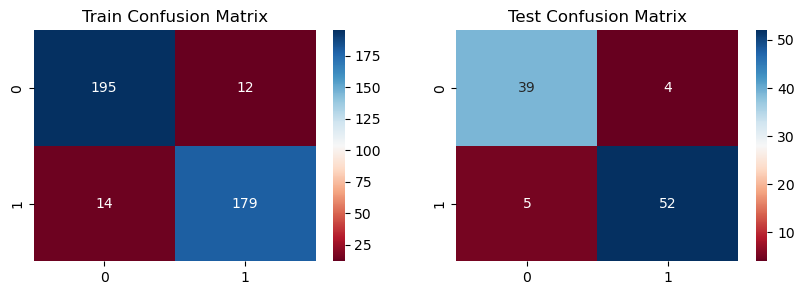

In [66]:
# let's have a look at the classification report and confution matrix
score_show('LogisticRegression',LR_gridSearch, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 39 times and not retire 52 times. However, the model made a false positive error 4 times and a false negative error 5 times.

## Step #3.5: Gaussian NB

In [67]:
# training the model using Pipeline with Grid Search
NB_pipe=Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                  ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                  ('Discretization',EqualFrequencyDiscretiser(q = 10,variables = 'Age')),
                  ('Scaler',StandardScaler()),
                  ('GaussianNB',GaussianNB())])

params_NB = [{
        'Imputation_Age' : [im.ArbitraryNumberImputer(variables=['Age']),
                            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
                            im.MeanMedianImputer(imputation_method='median',variables=['Age'])],
        'Imputation_401K' : [im.ArbitraryNumberImputer(variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='median',variables=['401K Savings'])],
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables='Age'),
                            EqualFrequencyDiscretiser(q=10,variables='Age'),
                            EqualWidthDiscretiser(bins=5,variables='Age'),
                            EqualWidthDiscretiser(bins=10,variables='Age')],
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()]
    }]

NB_gridSearch = GridSearchCV(estimator = NB_pipe, param_grid = params_NB, cv = 5, n_jobs = -1, scoring = 'accuracy')
NB_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('Discretization',
                                        EqualFrequencyDiscretiser(variables='Age')),
                                       ('Scaler', StandardScaler()),
                                       ('GaussianNB', GaussianNB())]),
             n_jobs=-1,
             param_grid=[{'Discretization': [EqualFrequencyDiscreti...
                                              MeanMedianImputer(imputation_method='mean',
                                                                variables=['401K '
                                                                           'Savings']),
                                              MeanMedianImputer(variables=['401K '
                                                                           'Savings'])],
                          'Imputation_Age': [ArbitraryNumberImputer(variables=['Age']),
                                             MeanMedianImputer(imputation_method='mean',
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age'])],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [68]:
# selection of the best parameters
NB_gridSearch.best_params_

{'Discretization': EqualWidthDiscretiser(variables='Age'),
 'Imputation_401K': MeanMedianImputer(imputation_method='mean', variables=['401K Savings']),
 'Imputation_Age': MeanMedianImputer(imputation_method='mean', variables=['Age']),
 'Scaler': StandardScaler()}

Train: 
accuracy 0.9475
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       207
           1       0.94      0.95      0.95       193

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

------------------------------------------------------
Test: 
accuracy 0.95
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.95      0.96      0.96        57

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



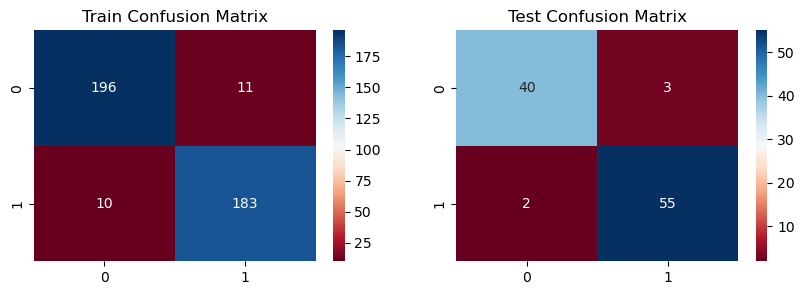

In [69]:
# let's have a look at the classification report and confution matrix
score_show('GaussianNB',NB_gridSearch, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 40 times and not retire 55 times. However, the model made a false positive error 3 times and a false negative error 2 times.

## Step #3.6: XGBClassifier

In [70]:
# training the model using Pipeline with Grid Search
XGB_pipe=Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                  ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                  ('Discretization',EqualFrequencyDiscretiser(q = 10,variables = 'Age')),
#                  ('Scaler',StandardScaler()),
                  ('XGBClassifier',XGBClassifier())])

params_XGB = [{
        'Imputation_Age' : [im.ArbitraryNumberImputer(variables=['Age']),
                            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
                            im.MeanMedianImputer(imputation_method='median',variables=['Age'])],
        'Imputation_401K' : [im.ArbitraryNumberImputer(variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='median',variables=['401K Savings'])],
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables='Age'),
                            EqualFrequencyDiscretiser(q=10,variables='Age'),
                            EqualWidthDiscretiser(bins=5,variables='Age'),
                            EqualWidthDiscretiser(bins=10,variables='Age')],
#        'Scaler' : [StandardScaler(),
#                    RobustScaler(),
#                    MinMaxScaler()],
        'XGBClassifier__gamma': [0,1,2],
        'XGBClassifier__max_depth':[1,2]
    }]

XGB_gridSearch = GridSearchCV(estimator = XGB_pipe, param_grid = params_XGB, cv = 5, n_jobs = -1, scoring = 'accuracy')
XGB_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('Discretization',
                                        EqualFrequencyDiscretiser(variables='Age')),
                                       ('XGBClassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      c...
                                              MeanMedianImputer(imputation_method='mean',
                                                                variables=['401K '
                                                                           'Savings']),
                                              MeanMedianImputer(variables=['401K '
                                                                           'Savings'])],
                          'Imputation_Age': [ArbitraryNumberImputer(variables=['Age']),
                                             MeanMedianImputer(imputation_method='mean',
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age'])],
                          'XGBClassifier__gamma': [0, 1, 2],
                          'XGBClassifier__max_depth': [1, 2]}],
             scoring='accuracy')

In [71]:
# selection of the best parameters
XGB_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables='Age'),
 'Imputation_401K': MeanMedianImputer(imputation_method='mean', variables=['401K Savings']),
 'Imputation_Age': MeanMedianImputer(variables=['Age']),
 'XGBClassifier__gamma': 1,
 'XGBClassifier__max_depth': 1}

Train: 
accuracy 0.95
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       207
           1       0.95      0.94      0.95       193

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

------------------------------------------------------
Test: 
accuracy 0.94
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.95      0.95      0.95        57

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



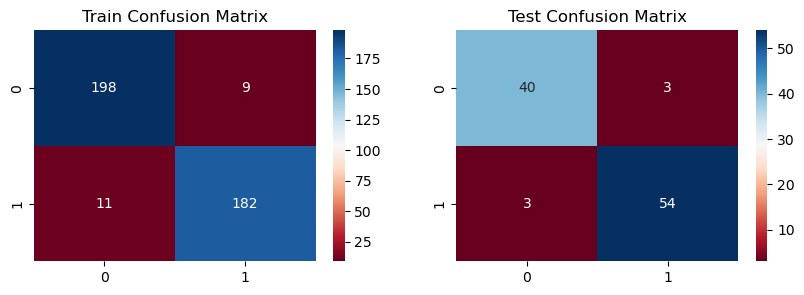

In [72]:
# let's have a look at the classification report and confution matrix
score_show('XGBClassifier',XGB_gridSearch, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 40 times and not retire 54 times. However, the model made a false positive error 3 times and a false negative error 3 times.

## Step #3.7: Support Vector Classifier

In [73]:
# training the model using Pipeline with Grid Search
SVC_pipe=Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                  ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                  ('Discretization',EqualFrequencyDiscretiser(q = 10,variables = 'Age')),
                  ('Scaler',StandardScaler()),
                  ('SVC',SVC())])

params_SVC = [{
        'Imputation_Age' : [im.ArbitraryNumberImputer(variables=['Age']),
                            im.MeanMedianImputer(imputation_method='mean',variables=['Age']),
                            im.MeanMedianImputer(imputation_method='median',variables=['Age'])],
        'Imputation_401K' : [im.ArbitraryNumberImputer(variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='mean',variables=['401K Savings']),
                             im.MeanMedianImputer(imputation_method='median',variables=['401K Savings'])],
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables='Age'),
                            EqualFrequencyDiscretiser(q=10,variables='Age'),
                            EqualWidthDiscretiser(bins=5,variables='Age'),
                            EqualWidthDiscretiser(bins=10,variables='Age')],
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()],
        'SVC__gamma': [0.1,0.2,0.3],
        'SVC__degree': [1,2,3],
        'SVC__probability': [True]
    }]

SVC_gridSearch = GridSearchCV(estimator =SVC_pipe, param_grid = params_SVC, cv = 5, n_jobs = -1, scoring = 'accuracy')
SVC_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation_Age',
                                        MeanMedianImputer(variables=['Age'])),
                                       ('Imputation_401K',
                                        MeanMedianImputer(variables=['401K '
                                                                     'Savings'])),
                                       ('Discretization',
                                        EqualFrequencyDiscretiser(variables='Age')),
                                       ('Scaler', StandardScaler()),
                                       ('SVC', SVC())]),
             n_jobs=-1,
             param_grid=[{'Discretization': [EqualFrequencyDiscretiser(q=5,
                                                                       variab...
                                              MeanMedianImputer(variables=['401K '
                                                                           'Savings'])],
                          'Imputation_Age': [ArbitraryNumberImputer(variables=['Age']),
                                             MeanMedianImputer(imputation_method='mean',
                                                               variables=['Age']),
                                             MeanMedianImputer(variables=['Age'])],
                          'SVC__degree': [1, 2, 3],
                          'SVC__gamma': [0.1, 0.2, 0.3],
                          'SVC__probability': [True],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [74]:
# selection of the best parameters
SVC_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables='Age'),
 'Imputation_401K': MeanMedianImputer(imputation_method='mean', variables=['401K Savings']),
 'Imputation_Age': MeanMedianImputer(imputation_method='mean', variables=['Age']),
 'SVC__degree': 1,
 'SVC__gamma': 0.1,
 'SVC__probability': True,
 'Scaler': RobustScaler()}

Train: 
accuracy 0.9425
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       207
           1       0.94      0.94      0.94       193

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400

------------------------------------------------------
Test: 
accuracy 0.92
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        43
           1       0.95      0.91      0.93        57

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



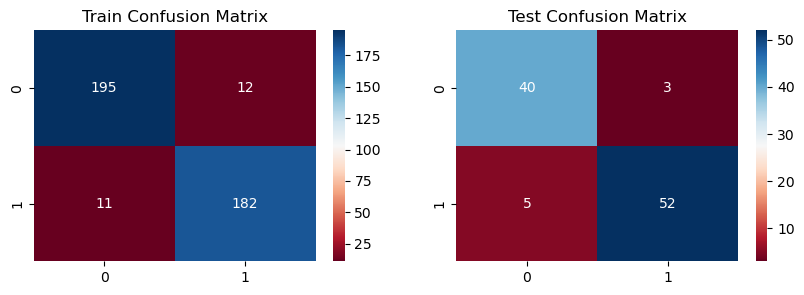

In [75]:
# let's have a look at the classification report and confution matrix
score_show('SVC',SVC_gridSearch, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 40 times and not retire 52 times. However, the model made a false positive error 3 times and a false negative error 5 times.

 ## Step #3.8 Super Learner

In [76]:
# create pipline
pipe = Pipeline([('Imputation_Age',im.MeanMedianImputer(variables=['Age'])),
                 ('Imputation_401K',im.MeanMedianImputer(variables=['401K Savings'])),
                 ('discretization',EqualFrequencyDiscretiser(q = 5,variables = 'Age')),
                 ('Sc',StandardScaler())])
X_train=pipe.fit_transform(X_train)
X_test=pipe.transform(X_test)

In [77]:
# create a list of base-models
def get_models():
    models = list()    
    models.append(DecisionTreeClassifier(max_depth=4, min_samples_leaf=1))
    models.append(RandomForestClassifier(max_depth=3,min_samples_leaf=1,n_estimators=100))
    models.append(KNeighborsClassifier(n_neighbors=20))
    models.append(LogisticRegression(C=10.0))
    models.append(GaussianNB())
    models.append(XGBClassifier(gamma=1,max_depth=2 ))
    models.append(SVC(degree=2.0,gamma=0.1))
    return models
# create the super learner
def get_super_learner(X):
    ensemble = SuperLearner(scorer = accuracy_score,folds = 30,shuffle = False,sample_size = len(X_train))
    models = get_models()
    ensemble.add(models)
    ensemble.add_meta(XGBClassifier(gamma = 1,max_depth = 2))
    return ensemble
# create the super learner
ensemble = get_super_learner(X)
ensemble.fit(X_train,y_train)

SuperLearner(array_check=None, backend=None, folds=30,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=30, raise_on_e...ED091F0>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=400,
       scorer=<function accuracy_score at 0x0000016F7ED091F0>,
       shuffle=False, verbose=False)

Train: 
accuracy 0.95
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       207
           1       0.93      0.96      0.95       193

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

------------------------------------------------------
Test: 
accuracy 0.92
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        43
           1       0.93      0.93      0.93        57

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



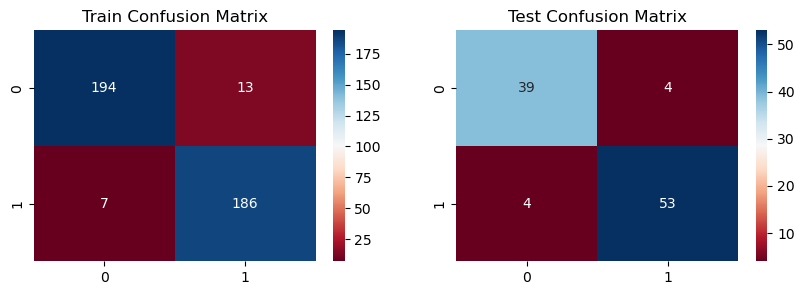

In [78]:
# let's have a look at the classification report and confution matrix
score_show('SuperLearner',ensemble, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted that a person would retire 39 times and not retire 53 times. However, the model made a false positive error 4 times and a false negative error 4 times.

## Step #4: Record Classification Metrics

In [79]:
# let's look at the results
show_results(results)

,modelName,accuracy_test,rocauc_test,precision_test,recall_test,f1_test
4,GaussianNB,0.95,0.947572,0.948276,0.964912,0.956522
1,RandomForestClassifier,0.94,0.938800,0.947368,0.947368,0.947368
5,XGBClassifier,0.94,0.938800,0.947368,0.947368,0.947368
0,DecisionTreeClassifier,0.93,0.927173,0.931034,0.947368,0.939130
2,KNeighborsClassifier,0.92,0.921257,0.945455,0.912281,0.928571
6,SVC,0.92,0.921257,0.945455,0.912281,0.928571
7,SuperLearner,0.92,0.918401,0.929825,0.929825,0.929825
3,LogisticRegression,0.91,0.909629,0.928571,0.912281,0.920354


## Conclusion

 We tried several modeling approaches to predict the result of whether a customer is able to retire.
* Performed an analysis of each variable and the relationship between them, as well as imputation analysis, discretization  analysis variable 'Age' and variables scaling analysis.
* With the help of the pipeline, we found the optimal hyperparameters and trained 8 models.
* Trained the model with various hyperparameters, metrics and found that the best model is the GaussianNB.
* The worst model is LogisticRegression with an accuracy of 91%
* Analysis showed that people over 50 years old most often retire, and their deposit is from $ 620,000.